# Emotion Classification: Model Training with Transfer Learning

This notebook implements the training pipeline for emotion classification using EfficientNet-B0 with transfer learning on the FER-2013 dataset.

## Model Architecture
- **Base Model**: EfficientNet-B0 (pre-trained on ImageNet)
- **Approach**: Transfer learning with fine-tuning
- **Input**: 224×224 RGB images (converted from 48×48 grayscale)
- **Output**: 7-class emotion classification
- **Framework**: PyTorch → ONNX export for production


In [10]:
# Import required libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import models, transforms
from torch.amp import autocast, GradScaler
import numpy as np
import pandas as pd
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

print("Libraries imported successfully!")


Libraries imported successfully!


## 1. Device Setup and GPU Configuration


In [2]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# GPU information
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Version: {torch.version.cuda}")
    print(f"cuDNN Version: {torch.backends.cudnn.version()}")
    # Enable cuDNN benchmark for faster training
    torch.backends.cudnn.benchmark = True
    print("cuDNN benchmark enabled")
else:
    print("CUDA not available. Training will be slower on CPU.")

# Set number of classes
NUM_CLASSES = 7
EMOTIONS = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
EMOTION_TO_IDX = {emotion: idx for idx, emotion in enumerate(EMOTIONS)}
IDX_TO_EMOTION = {idx: emotion for emotion, idx in EMOTION_TO_IDX.items()}

print(f"\nNumber of classes: {NUM_CLASSES}")
print(f"Emotion classes: {EMOTIONS}")


Using device: cuda
GPU: NVIDIA GeForce RTX 3050
CUDA Version: 13.0
cuDNN Version: 91300
cuDNN benchmark enabled

Number of classes: 7
Emotion classes: ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']


## 2. Dataset Paths and Configuration


In [3]:
# Define dataset paths
BASE_DIR = Path('../data/fer2013')
TRAIN_DIR = BASE_DIR / 'train'
TEST_DIR = BASE_DIR / 'test'

# Training hyperparameters
BATCH_SIZE = 32
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-4
NUM_EPOCHS_PHASE1 = 3  # Frozen backbone
NUM_EPOCHS_PHASE2 = 5  # Fine-tuning
VALIDATION_SPLIT = 0.1  # 10% of training data for validation
EARLY_STOPPING_PATIENCE = 3

print(f"Base directory: {BASE_DIR}")
print(f"Train directory exists: {TRAIN_DIR.exists()}")
print(f"Test directory exists: {TEST_DIR.exists()}")
print(f"\nTraining configuration:")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Weight decay: {WEIGHT_DECAY}")
print(f"  Phase 1 epochs (frozen): {NUM_EPOCHS_PHASE1}")
print(f"  Phase 2 epochs (fine-tune): {NUM_EPOCHS_PHASE2}")


Base directory: ../data/fer2013
Train directory exists: True
Test directory exists: True

Training configuration:
  Batch size: 32
  Learning rate: 0.0001
  Weight decay: 0.0001
  Phase 1 epochs (frozen): 3
  Phase 2 epochs (fine-tune): 5


## 3. Custom Dataset Class


In [4]:
class FER2013Dataset(Dataset):
    """Custom Dataset class for FER-2013 dataset."""
    
    def __init__(self, data_dir, transform=None):
        """
        Args:
            data_dir: Path to directory containing emotion subdirectories
            transform: Optional transform to be applied on a sample
        """
        self.data_dir = Path(data_dir)
        self.transform = transform
        self.samples = []
        
        # Load all image paths with their labels
        for emotion in EMOTIONS:
            emotion_dir = self.data_dir / emotion
            if emotion_dir.exists():
                image_files = list(emotion_dir.glob('*.jpg')) + list(emotion_dir.glob('*.png'))
                for img_path in image_files:
                    self.samples.append((img_path, EMOTION_TO_IDX[emotion]))
        
        print(f"Loaded {len(self.samples)} samples from {data_dir}")
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        
        # Load image
        try:
            image = Image.open(img_path).convert('RGB')  # Convert grayscale to RGB
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            # Return a black image as fallback
            image = Image.new('RGB', (48, 48), color='black')
        
        # Apply transforms
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Test dataset class
if TRAIN_DIR.exists():
    test_dataset = FER2013Dataset(TRAIN_DIR, transform=None)
    print(f"\nDataset test successful! Found {len(test_dataset)} samples")
else:
    print("\n⚠️  Dataset not found. Please download the dataset first.")


Loaded 28709 samples from ../data/fer2013/train

Dataset test successful! Found 28709 samples


## 4. Data Transforms and Augmentation


In [5]:
# ImageNet normalization statistics (for pre-trained models)
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

# Training transforms with data augmentation
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize from 48x48 to 224x224
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

# Validation/Test transforms (no augmentation)
val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

print("Transforms defined:")
print("\nTraining transforms:")
print(train_transform)
print("\nValidation/Test transforms:")
print(val_test_transform)


Transforms defined:

Training transforms:
Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    RandomHorizontalFlip(p=0.5)
    RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
    ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=None, hue=None)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

Validation/Test transforms:
Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


## 5. Create DataLoaders


In [6]:
# Create datasets
if TRAIN_DIR.exists() and TEST_DIR.exists():
    # Training dataset
    train_dataset_full = FER2013Dataset(TRAIN_DIR, transform=train_transform)
    
    # Split training data into train and validation
    train_size = int((1 - VALIDATION_SPLIT) * len(train_dataset_full))
    val_size = len(train_dataset_full) - train_size
    train_dataset, val_dataset = random_split(
        train_dataset_full, 
        [train_size, val_size],
        generator=torch.Generator().manual_seed(42)
    )
    
    # Update validation dataset transforms (no augmentation)
    val_dataset.dataset = FER2013Dataset(TRAIN_DIR, transform=val_test_transform)
    val_indices = val_dataset.indices
    val_dataset = torch.utils.data.Subset(
        FER2013Dataset(TRAIN_DIR, transform=val_test_transform),
        val_indices
    )
    
    # Test dataset
    test_dataset = FER2013Dataset(TEST_DIR, transform=val_test_transform)
    
    # Create DataLoaders
    train_loader = DataLoader(
        train_dataset, 
        batch_size=BATCH_SIZE, 
        shuffle=True, 
        num_workers=2,
        pin_memory=True if torch.cuda.is_available() else False
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=2,
        pin_memory=True if torch.cuda.is_available() else False
    )
    
    test_loader = DataLoader(
        test_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=2,
        pin_memory=True if torch.cuda.is_available() else False
    )
    
    print(f"DataLoaders created:")
    print(f"  Train batches: {len(train_loader)} ({len(train_dataset)} samples)")
    print(f"  Validation batches: {len(val_loader)} ({len(val_dataset)} samples)")
    print(f"  Test batches: {len(test_loader)} ({len(test_dataset)} samples)")
else:
    print("⚠️  Dataset directories not found. Please download the dataset first.")
    train_loader = None
    val_loader = None
    test_loader = None


Loaded 28709 samples from ../data/fer2013/train
Loaded 28709 samples from ../data/fer2013/train
Loaded 28709 samples from ../data/fer2013/train
Loaded 7178 samples from ../data/fer2013/test
DataLoaders created:
  Train batches: 808 (25838 samples)
  Validation batches: 90 (2871 samples)
  Test batches: 225 (7178 samples)


## 6. Model Architecture: EfficientNet-B0 with Transfer Learning


In [7]:
def create_model(num_classes=7, freeze_backbone=True):
    """
    Create EfficientNet-B0 model with transfer learning.
    
    Args:
        num_classes: Number of output classes (7 for FER-2013)
        freeze_backbone: If True, freeze feature extraction layers
    
    Returns:
        model: PyTorch model
    """
    # Load pre-trained EfficientNet-B0
    model = models.efficientnet_b0(weights='IMAGENET1K_V1')
    
    # Freeze backbone layers (Phase 1 training)
    if freeze_backbone:
        for param in model.features.parameters():
            param.requires_grad = False
        print("Backbone layers frozen")
    else:
        print("All layers trainable (fine-tuning)")
    
    # Replace classifier head for our number of classes
    # EfficientNet-B0 classifier structure: Dropout -> Linear
    in_features = model.classifier[1].in_features
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3),
        nn.Linear(in_features, num_classes)
    )
    
    print(f"Model created: EfficientNet-B0")
    print(f"  Input features: {in_features}")
    print(f"  Output classes: {num_classes}")
    
    return model

# Create model
model = create_model(num_classes=NUM_CLASSES, freeze_backbone=True)
model = model.to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nModel parameters:")
print(f"  Total: {total_params:,}")
print(f"  Trainable: {trainable_params:,}")
print(f"  Frozen: {total_params - trainable_params:,}")


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /home/david/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 33.9MB/s]


Backbone layers frozen
Model created: EfficientNet-B0
  Input features: 1280
  Output classes: 7

Model parameters:
  Total: 4,016,515
  Trainable: 8,967
  Frozen: 4,007,548


## 7. Training Configuration


In [11]:
# Calculate class weights for imbalanced dataset (optional)
# This helps with the class imbalance issue (especially Disgust class)
def calculate_class_weights(dataset):
    """Calculate class weights based on class frequencies."""
    class_counts = torch.zeros(NUM_CLASSES)
    
    for _, label in dataset:
        class_counts[label] += 1
    
    # Calculate weights (inverse frequency)
    total = class_counts.sum()
    class_weights = total / (NUM_CLASSES * class_counts)
    class_weights = class_weights / class_weights.sum() * NUM_CLASSES  # Normalize
    
    return class_weights

# Calculate class weights if dataset is available
if train_loader is not None:
    # Get full training dataset for weight calculation
    full_train_dataset = FER2013Dataset(TRAIN_DIR, transform=None)
    class_weights = calculate_class_weights(full_train_dataset)
    class_weights = class_weights.to(device)
    print("Class weights calculated:")
    for i, emotion in enumerate(EMOTIONS):
        print(f"  {emotion:10s}: {class_weights[i]:.4f}")
else:
    class_weights = None
    print("Class weights not calculated (dataset not available)")

# Loss function
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Optimizer
optimizer = optim.AdamW(
    model.parameters(),
    lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY
)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=2
)

# Mixed precision training scaler
scaler = GradScaler('cuda')

print(f"\nTraining configuration:")
print(f"  Loss function: CrossEntropyLoss (with class weights: {class_weights is not None})")
print(f"  Optimizer: AdamW (lr={LEARNING_RATE}, weight_decay={WEIGHT_DECAY})")
print(f"  Scheduler: ReduceLROnPlateau (factor=0.5, patience=2)")
print(f"  Mixed precision: Enabled")


Loaded 28709 samples from ../data/fer2013/train
Class weights calculated:
  angry     : 0.4800
  disgust   : 4.3982
  fear      : 0.4681
  happy     : 0.2658
  sad       : 0.3970
  surprise  : 0.6047
  neutral   : 0.3862

Training configuration:
  Loss function: CrossEntropyLoss (with class weights: True)
  Optimizer: AdamW (lr=0.0001, weight_decay=0.0001)
  Scheduler: ReduceLROnPlateau (factor=0.5, patience=2)
  Mixed precision: Enabled


## 8. Training Functions


In [12]:
def train_epoch(model, dataloader, criterion, optimizer, device, scaler):
    """Train for one epoch."""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    progress_bar = tqdm(dataloader, desc='Training')
    for images, labels in progress_bar:
        images = images.to(device)
        labels = labels.to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass with mixed precision
        with autocast('cuda'):
            outputs = model(images)
            loss = criterion(outputs, labels)
        
        # Backward pass with scaler
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        # Statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Update progress bar
        progress_bar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{100 * correct / total:.2f}%'
        })
    
    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100 * correct / total
    
    return epoch_loss, epoch_acc

def validate_epoch(model, dataloader, criterion, device):
    """Validate for one epoch."""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        progress_bar = tqdm(dataloader, desc='Validation')
        for images, labels in progress_bar:
            images = images.to(device)
            labels = labels.to(device)
            
            # Forward pass
            with autocast('cuda'):
                outputs = model(images)
                loss = criterion(outputs, labels)
            
            # Statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            # Update progress bar
            progress_bar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{100 * correct / total:.2f}%'
            })
    
    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100 * correct / total
    
    return epoch_loss, epoch_acc, all_preds, all_labels

print("Training functions defined successfully!")


Training functions defined successfully!


## 9. Training Loop Structure

The training will be done in two phases:
1. **Phase 1**: Train only classifier head (backbone frozen) - 3 epochs
2. **Phase 2**: Fine-tune entire model (all layers trainable) - 5 epochs

### Phase 1: Frozen Backbone Training


In [ ]:
# Training history
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

# Early stopping
best_val_loss = float('inf')
patience_counter = 0

# Create models directory if it doesn't exist
models_dir = Path('../models')
models_dir.mkdir(parents=True, exist_ok=True)
print(f"Models directory: {models_dir.absolute()}")

if train_loader is not None:
    print("=" * 60)
    print("PHASE 1: Training Classifier Head (Backbone Frozen)")
    print("=" * 60)
    
    for epoch in range(NUM_EPOCHS_PHASE1):
        print(f"\nEpoch {epoch + 1}/{NUM_EPOCHS_PHASE1}")
        print("-" * 60)
        
        # Train
        train_loss, train_acc = train_epoch(
            model, train_loader, criterion, optimizer, device, scaler
        )
        
        # Validate
        val_loss, val_acc, _, _ = validate_epoch(
            model, val_loader, criterion, device
        )
        
        # Update learning rate
        scheduler.step(val_loss)
        
        # Save history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        # Print epoch results
        print(f"\nEpoch {epoch + 1} Results:")
        print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
        print(f"  Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
        print(f"  Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")
        
        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            # Save best model
            torch.save(model.state_dict(), '../models/best_model_phase1.pth')
            print("  ✓ Best model saved!")
        else:
            patience_counter += 1
            if patience_counter >= EARLY_STOPPING_PATIENCE:
                print(f"  Early stopping triggered after {epoch + 1} epochs")
                break
else:
    print("⚠️  Cannot train: DataLoaders not available. Please download dataset first.")


Models directory: /home/david/github/emotion-detection-app/notebooks/../models
PHASE 1: Training Classifier Head (Backbone Frozen)

Epoch 1/3
------------------------------------------------------------


Validation: 100%|██████████| 90/90 [00:03<00:00, 24.11it/s, loss=1.6738, acc=35.18%]



Epoch 1 Results:
  Train Loss: 1.7808 | Train Acc: 33.14%
  Val Loss: 1.7758 | Val Acc: 35.18%
  Learning Rate: 0.000100
  ✓ Best model saved!

Epoch 2/3
------------------------------------------------------------


Validation: 100%|██████████| 90/90 [00:03<00:00, 23.54it/s, loss=1.6614, acc=35.46%]



Epoch 2 Results:
  Train Loss: 1.7410 | Train Acc: 34.83%
  Val Loss: 1.7411 | Val Acc: 35.46%
  Learning Rate: 0.000100
  ✓ Best model saved!

Epoch 3/3
------------------------------------------------------------


Validation: 100%|██████████| 90/90 [00:03<00:00, 24.63it/s, loss=1.6384, acc=35.21%]



Epoch 3 Results:
  Train Loss: 1.7081 | Train Acc: 36.03%
  Val Loss: 1.7185 | Val Acc: 35.21%
  Learning Rate: 0.000100
  ✓ Best model saved!


### Phase 2: Fine-tuning (All Layers Trainable)


In [ ]:
# Unfreeze all layers for fine-tuning
if train_loader is not None:
    print("\n" + "=" * 60)
    print("PHASE 2: Fine-tuning All Layers")
    print("=" * 60)
    
    # Unfreeze backbone
    for param in model.features.parameters():
        param.requires_grad = True
    
    # Use lower learning rate for fine-tuning
    optimizer = optim.AdamW(
        model.parameters(),
        lr=LEARNING_RATE * 0.1,  # 10x lower learning rate
        weight_decay=WEIGHT_DECAY
    )
    
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.5,
        patience=2
    )
    
    # Reset early stopping
    best_val_loss = min(history['val_loss']) if history['val_loss'] else float('inf')
    patience_counter = 0
    
    print(f"Unfroze all layers. Fine-tuning with lr={optimizer.param_groups[0]['lr']:.6f}")
    
    for epoch in range(NUM_EPOCHS_PHASE2):
        print(f"\nEpoch {epoch + 1}/{NUM_EPOCHS_PHASE2}")
        print("-" * 60)
        
        # Train
        train_loss, train_acc = train_epoch(
            model, train_loader, criterion, optimizer, device, scaler
        )
        
        # Validate
        val_loss, val_acc, _, _ = validate_epoch(
            model, val_loader, criterion, device
        )
        
        # Update learning rate
        scheduler.step(val_loss)
        
        # Save history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        # Print epoch results
        print(f"\nEpoch {epoch + 1} Results:")
        print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
        print(f"  Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
        print(f"  Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")
        
        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            # Save best model
            torch.save(model.state_dict(), '../models/best_model_phase2.pth')
            print("  ✓ Best model saved!")
        else:
            patience_counter += 1
            if patience_counter >= EARLY_STOPPING_PATIENCE:
                print(f"  Early stopping triggered after {epoch + 1} epochs")
                break
else:
    print("⚠️  Cannot fine-tune: DataLoaders not available.")



PHASE 2: Fine-tuning All Layers
Unfroze all layers. Fine-tuning with lr=0.000010

Epoch 1/5
------------------------------------------------------------


Training:   0%|          | 0/808 [00:00<?, ?it/s]

Validation: 100%|██████████| 90/90 [00:03<00:00, 25.86it/s, loss=1.4514, acc=44.20%]



Epoch 1 Results:
  Train Loss: 1.6244 | Train Acc: 40.49%
  Val Loss: 1.5557 | Val Acc: 44.20%
  Learning Rate: 0.000010
  ✓ Best model saved!

Epoch 2/5
------------------------------------------------------------


Validation: 100%|██████████| 90/90 [00:03<00:00, 29.38it/s, loss=1.3856, acc=47.47%]



Epoch 2 Results:
  Train Loss: 1.4997 | Train Acc: 45.94%
  Val Loss: 1.4436 | Val Acc: 47.47%
  Learning Rate: 0.000010
  ✓ Best model saved!

Epoch 3/5
------------------------------------------------------------


Validation: 100%|██████████| 90/90 [00:03<00:00, 25.76it/s, loss=1.3513, acc=50.37%]



Epoch 3 Results:
  Train Loss: 1.4040 | Train Acc: 49.00%
  Val Loss: 1.3611 | Val Acc: 50.37%
  Learning Rate: 0.000010
  ✓ Best model saved!

Epoch 4/5
------------------------------------------------------------


Validation: 100%|██████████| 90/90 [00:03<00:00, 27.27it/s, loss=1.3291, acc=52.53%]



Epoch 4 Results:
  Train Loss: 1.3341 | Train Acc: 50.98%
  Val Loss: 1.2968 | Val Acc: 52.53%
  Learning Rate: 0.000010
  ✓ Best model saved!

Epoch 5/5
------------------------------------------------------------


Validation: 100%|██████████| 90/90 [00:03<00:00, 27.59it/s, loss=1.3137, acc=53.22%]



Epoch 5 Results:
  Train Loss: 1.2636 | Train Acc: 53.34%
  Val Loss: 1.2437 | Val Acc: 53.22%
  Learning Rate: 0.000010
  ✓ Best model saved!


## 10. Training Curves Visualization


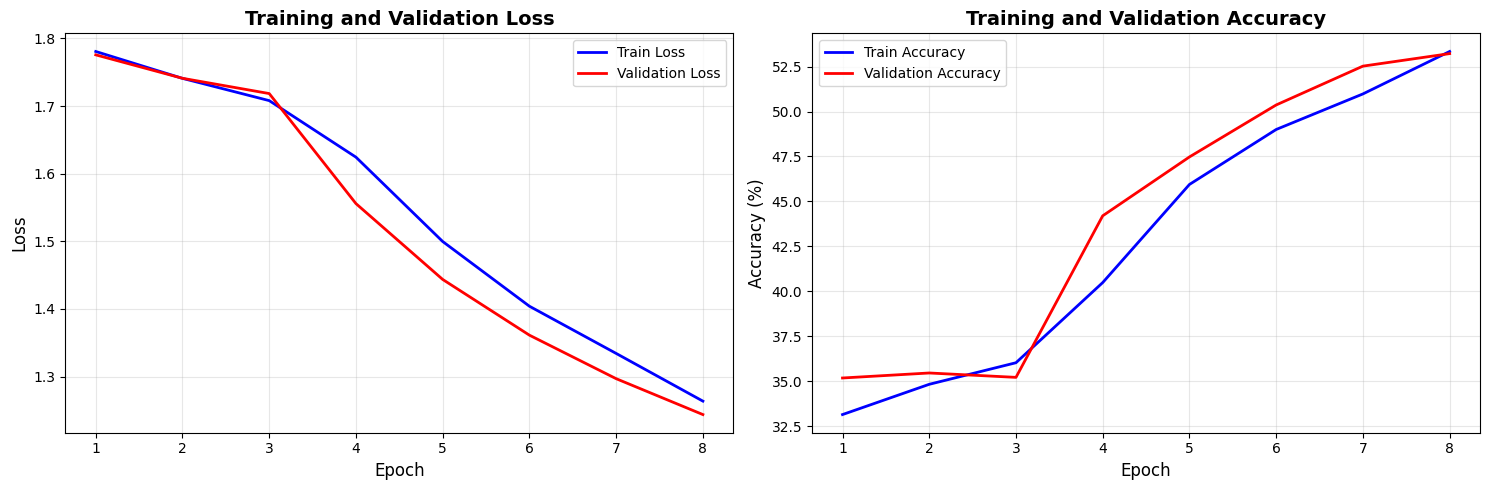


Final Results:
  Best Train Accuracy: 53.34%
  Best Validation Accuracy: 53.22%
  Best Validation Loss: 1.2437


In [18]:
# Plot training curves
if len(history['train_loss']) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    epochs = range(1, len(history['train_loss']) + 1)
    
    # Loss plot
    axes[0].plot(epochs, history['train_loss'], 'b-', label='Train Loss', linewidth=2)
    axes[0].plot(epochs, history['val_loss'], 'r-', label='Validation Loss', linewidth=2)
    axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Loss', fontsize=12)
    axes[0].legend()
    axes[0].grid(alpha=0.3)
    
    # Accuracy plot
    axes[1].plot(epochs, history['train_acc'], 'b-', label='Train Accuracy', linewidth=2)
    axes[1].plot(epochs, history['val_acc'], 'r-', label='Validation Accuracy', linewidth=2)
    axes[1].set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Accuracy (%)', fontsize=12)
    axes[1].legend()
    axes[1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nFinal Results:")
    print(f"  Best Train Accuracy: {max(history['train_acc']):.2f}%")
    print(f"  Best Validation Accuracy: {max(history['val_acc']):.2f}%")
    print(f"  Best Validation Loss: {min(history['val_loss']):.4f}")
else:
    print("No training history available. Run training cells first.")


## 11. Evaluation on Test Set


EVALUATION ON TEST SET
Loaded best model from Phase 2


Validation: 100%|██████████| 225/225 [00:14<00:00, 15.51it/s, loss=1.3242, acc=53.26%]



Test Results:
  Test Loss: 1.2266
  Test Accuracy: 53.26%


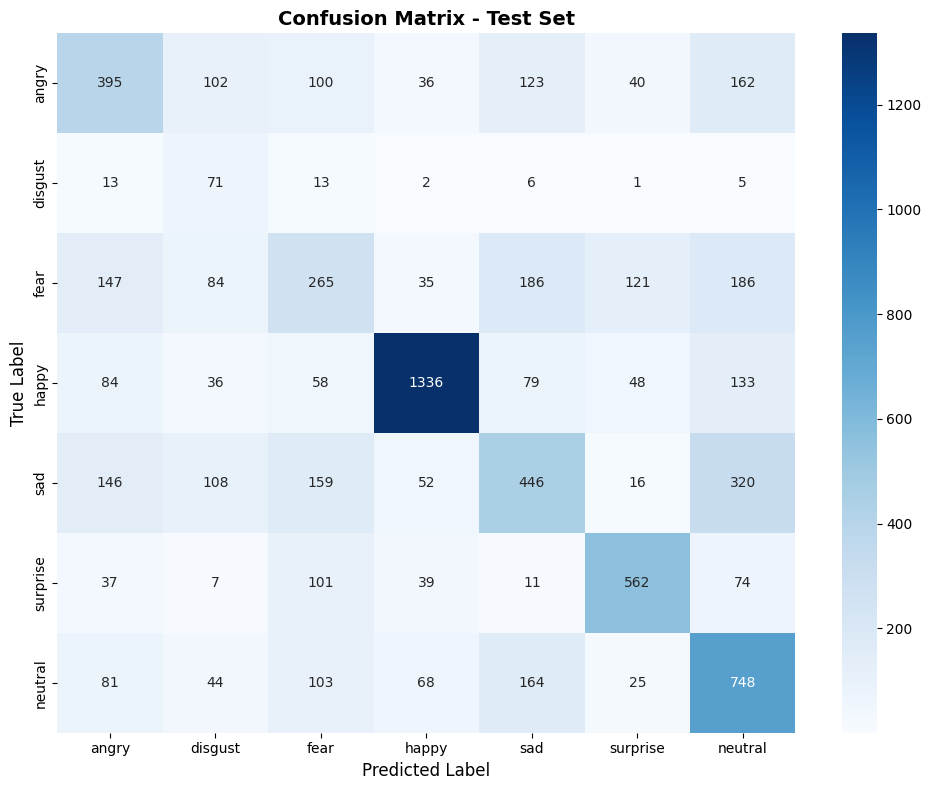


Classification Report:
              precision    recall  f1-score   support

       angry     0.4374    0.4123    0.4245       958
     disgust     0.1571    0.6396    0.2522       111
        fear     0.3317    0.2588    0.2907      1024
       happy     0.8520    0.7531    0.7995      1774
         sad     0.4394    0.3577    0.3943      1247
    surprise     0.6913    0.6763    0.6837       831
     neutral     0.4595    0.6067    0.5229      1233

    accuracy                         0.5326      7178
   macro avg     0.4812    0.5292    0.4811      7178
weighted avg     0.5540    0.5326    0.5371      7178


Per-Class Accuracy:
  angry     : 41.23%
  disgust   : 63.96%
  fear      : 25.88%
  happy     : 75.31%
  sad       : 35.77%
  surprise  : 67.63%
  neutral   : 60.67%


In [ ]:
# Load best model and evaluate on test set
if test_loader is not None:
    print("=" * 60)
    print("EVALUATION ON TEST SET")
    print("=" * 60)
    
    # Load best model
    try:
        model.load_state_dict(torch.load('../models/best_model_phase2.pth'))
        print("Loaded best model from Phase 2")
    except:
        try:
            model.load_state_dict(torch.load('../models/best_model_phase1.pth'))
            print("Loaded best model from Phase 1")
        except:
            print("Using current model state")
    
    model.eval()
    
    # Evaluate
    test_loss, test_acc, test_preds, test_labels = validate_epoch(
        model, test_loader, criterion, device
    )
    
    print(f"\nTest Results:")
    print(f"  Test Loss: {test_loss:.4f}")
    print(f"  Test Accuracy: {test_acc:.2f}%")
    
    # Confusion matrix
    cm = confusion_matrix(test_labels, test_preds)
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=EMOTIONS, yticklabels=EMOTIONS)
    plt.title('Confusion Matrix - Test Set', fontsize=14, fontweight='bold')
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    plt.show()
    
    # Classification report
    print("\nClassification Report:")
    print(classification_report(test_labels, test_preds, 
                              target_names=EMOTIONS, digits=4))
    
    # Per-class accuracy
    print("\nPer-Class Accuracy:")
    for i, emotion in enumerate(EMOTIONS):
        class_mask = np.array(test_labels) == i
        if class_mask.sum() > 0:
            class_acc = (np.array(test_preds)[class_mask] == i).sum() / class_mask.sum() * 100
            print(f"  {emotion:10s}: {class_acc:.2f}%")
else:
    print("⚠️  Cannot evaluate: Test DataLoader not available.")


## 12. Save Final Model

The model will be exported to ONNX format in the next notebook (03_onnx_validation.ipynb) for production deployment.


In [ ]:
# Save final model state
if test_loader is not None:
    # Create models directory if it doesn't exist
    Path('../models').mkdir(exist_ok=True)
    
    # Save PyTorch model
    torch.save(model.state_dict(), '../models/final_model.pth')
    print("Final model saved to ../models/final_model.pth")
    
    # Save model architecture info
    model_info = {
        'num_classes': NUM_CLASSES,
        'emotions': EMOTIONS,
        'emotion_to_idx': EMOTION_TO_IDX,
        'idx_to_emotion': IDX_TO_EMOTION,
        'test_accuracy': test_acc if 'test_acc' in locals() else None
    }
    
    import json
    with open('../models/model_info.json', 'w') as f:
        json.dump(model_info, f, indent=2)
    print("Model info saved to ../models/model_info.json")
    
    print("\n✓ Model training pipeline complete!")
    print("  Next step: Export to ONNX format (see 03_onnx_validation.ipynb)")
else:
    print("⚠️  Cannot save model: Evaluation not completed.")


Final model saved to ../models/final_model.pth
Model info saved to ../models/model_info.json

✓ Model training pipeline complete!
  Next step: Export to ONNX format (see 03_onnx_validation.ipynb)
